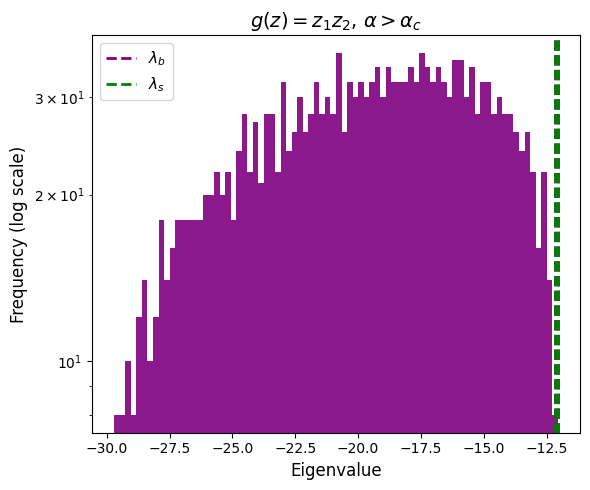

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from tqdm import tqdm

# --- Config ---
d, p = 1000, 2
alpha = 20
n = int(alpha * d)
bandwidth = 0.3

# --- Data Generation ---
def generate_data(n, d, p):
    W_star = np.linalg.qr(np.random.randn(d, p))[0]
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    return X, Z, y, W_star

# --- Kernel Conditional Expectation Estimation ---
def estimate_G_list(Z, y, bandwidth=0.3):
    n, p = Z.shape
    zzT = np.einsum('ni,nj->nij', Z, Z)
    zzT_mean = zzT - np.eye(p)[None, :, :]
    G_list = []
    for i in range(n):
        diff = (y[i] - y) / bandwidth
        weights = np.exp(-0.5 * diff**2)
        weights /= weights.sum()
        G_yi = np.tensordot(weights, zzT_mean, axes=([0], [0]))
        G_list.append(G_yi)
    return G_list

# --- Sparse Accumulation for Spectral Matrix ---
def build_symmetric_matrix(X, G_list):
    n, d = X.shape
    p = G_list[0].shape[0]
    T_blocks = np.zeros((d, d, p, p))
    for i in range(n):
        xi = X[i]
        Gi = G_list[i]
        outer_xx = np.outer(xi, xi)
        for a in range(p):
            for b in range(p):
                T_blocks[:, :, a, b] += outer_xx * Gi[a, b]
    T_matrix = T_blocks.transpose(0, 2, 1, 3).reshape(d * p, d * p)
    return T_matrix

# --- Compute bulk edge and signal eigenvalues ---
def compute_bulk_and_spikes(eigvals, top_k=5):
    eigvals_sorted = np.sort(eigvals)
    λ_b = eigvals_sorted[-(top_k + 1)]  # estimate of bulk edge
    λ_s = eigvals_sorted[-top_k:]      # top-k spikes
    return λ_b, λ_s

# --- Main Run ---
X, Z, y, W_star = generate_data(n, d, p)
G_list = estimate_G_list(Z, y, bandwidth=bandwidth)
T_matrix = build_symmetric_matrix(X, G_list)

# --- Eigen-decomposition ---
eigvals = np.linalg.eigvalsh(T_matrix)

# --- Identify bulk edge and signal spikes ---
λ_b, λ_s = compute_bulk_and_spikes(eigvals, top_k=3)

# --- Plotting: Spectrum Histogram ---
plt.figure(figsize=(6, 5))
plt.hist(eigvals, bins=80, color='purple', alpha=0.9, log=True)
plt.axvline(λ_b, color='purple', linestyle='--', linewidth=2, label=r'$\lambda_b$')
for λ in λ_s:
    plt.axvline(λ, color='green', linestyle='--', linewidth=2)
plt.axvline(λ_s[-1], color='green', linestyle='--', linewidth=2, label=r'$\lambda_s$')

plt.xlabel("Eigenvalue", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title(r"$g(z) = z_1 z_2$, $\alpha > \alpha_c$", fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


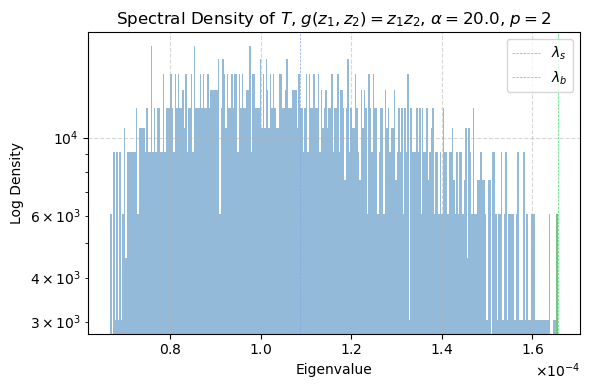

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter


def compute_T_y_bessel(y_batch):
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)


def build_T_hat(X, T_y):
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]  # (d,)
        Ti = T_y[i]  # (2,2)
        A = np.outer(xi, xi)  # (d,d)

        # 手动构造 Kronecker 加和
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


def plot_spectrum(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    bulk_color = '#2878B5'
    signal_color = 'green'

    # Histogram
    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

    # Plot
    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2) = z_1 z_2$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def main():
    # 参数设置
    d = 1000
    p = 2
    alpha = 20
    n = int(d * alpha)
    np.random.seed(42)

    # Step 1-4: 生成数据
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2

    # Step 5-6: 构造 T(y) 和 T_hat
    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y)

    # Step 7: 特征分解
    eigvals = eigh(T_hat, eigvals_only=True)

    # Step 8: 绘图
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]  # bulk 边缘
    plot_spectrum(eigvals, alpha=alpha, p=p, lambda_s=lambda_s, lambda_b=lambda_b)


if __name__ == "__main__":
    main()